# Train baseline ML methods

Credit: Sebastian Scher

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
import seaborn as sns
import pickle
from src.score import *
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [6]:
def limit_mem():
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    tf.compat.v1.Session(config=config)
def to_pickle(obj, fn):
    with open(fn, 'wb') as f:
        pickle.dump(obj, f)
def read_pickle(fn):
    with open(fn, 'rb') as f:
        return pickle.load(f)

In [7]:
limit_mem()

In [8]:
sns.set_style('darkgrid')
sns.set_context('notebook')

In [9]:
DATADIR = '/data/weather-benchmark/5.625deg/geopotential_500/'

In [10]:
PREDDIR = '/data/weather-benchmark/predictions/'

In [11]:
z500_valid = load_test_data(DATADIR)

/home/rasp/repositories/weather-benchmark/notebooks/src/score.py:24: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  ds = xr.open_mfdataset(f'{path}/*.nc')[var]
/home/rasp/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


## Load and preprocess dataset

In [12]:
z500 = xr.open_mfdataset(f'{DATADIR}*')

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/home/rasp/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [13]:
z500.load()

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 350640)
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 51555.703 51580.01 ... 48813.297 48731.062
Attributes:
    Conventions:  CF-1.6
    history:      2019-09-18 08:52:54 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...

In [14]:
data_train = z500.z.sel(time=slice('1979', '2016'))
data_test = z500.z.sel(time=slice('2017', '2018'))

In [15]:
# Compute mean and std for normalization
data_mean = data_train.mean().values
data_std = data_train.std('time').mean().values
data_mean, data_std

(array(54109.28, dtype=float32), array(1119.5938, dtype=float32))

In [16]:
# Normalize datasets
data_train = (data_train - data_mean) / data_std
data_test = (data_test - data_mean) / data_std

In [17]:
lead_time_h = 6

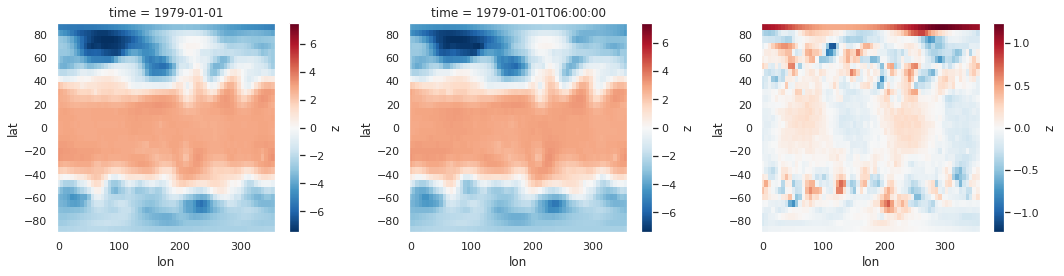

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
data_train.isel(time=0).plot(ax=ax1)
data_train.isel(time=lead_time_h).plot(ax=ax2)
(data_train.isel(time=lead_time_h) - data_train.isel(time=0)).plot(ax=ax3)
plt.tight_layout()

In [19]:
def create_training_data(data_train, lead_time_h, return_valid_time=False):
    X_train = data_train.isel(time=slice(0, -lead_time_h))
    y_train = data_train.isel(time=slice(lead_time_h, None))
    valid_time = y_train.time
    if return_valid_time:
        return X_train.values, y_train.values, valid_time
    else:
        return X_train.values, y_train.values

In [20]:
X_train, y_train = create_training_data(data_train, lead_time_h)

In [21]:
nsamples, nlat, nlon = X_train.shape
nsamples, nlat, nlon

(333114, 32, 64)

## Linear regression

### Directly forecast 3 and 5 days

In [22]:
def train_lr(lead_time_h):
    X_train, y_train = create_training_data(data_train, lead_time_h)
    X_test, y_test, valid_time = create_training_data(data_test, lead_time_h, return_valid_time=True)
    lr = LinearRegression()
    lr.fit(X_train.reshape((-1, nlat*nlon)), y_train.reshape((-1, nlat*nlon)))
    mse_train = mean_squared_error(
        y_train.reshape((-1, nlat*nlon)), lr.predict(X_train.reshape((-1, nlat*nlon))))
    mse_test = mean_squared_error(
        y_test.reshape((-1, nlat*nlon)), lr.predict(X_test.reshape((-1, nlat*nlon))))
    print(f'Train MSE = {mse_train}'); print(f'Test MSE = {mse_test}')
    preds = lr.predict(X_test.reshape((-1, nlat*nlon))).reshape((-1, nlat, nlon))
    fc = xr.DataArray(
        preds * data_std + data_mean, 
        dims=['time', 'lat', 'lon'],
        coords={
            'time': valid_time,
            'lat': data_test.lat,
            'lon': data_test.lon
        }
    )
    return fc, lr                                   

In [23]:
fc_3d, lr_3d = train_lr(3*24)

Train MSE = 0.4273567199707031
Test MSE = 0.519521176815033


In [67]:
lr_3d.coef_.max()

105.07893

In [24]:
fc_3d.to_netcdf(f'{PREDDIR}/fc_lr_3d.nc'); to_pickle(lr_3d, f'{PREDDIR}/lr_3d.pkl')

In [25]:
rmse_lr_3d = compute_weighted_rmse(fc_3d, z500_valid).values; rmse_lr_3d

array(692.72003308)

In [26]:
fc_5d, lr_5d = train_lr(5*24)

Train MSE = 0.5394009351730347
Test MSE = 0.6640067100524902


In [27]:
fc_5d.to_netcdf(f'{PREDDIR}/fc_lr_5d.nc'); to_pickle(lr_5d, f'{PREDDIR}/lr_5d.pkl')

In [28]:
rmse_lr_5d = compute_weighted_rmse(fc_5d, z500_valid).values; rmse_lr_5d

array(782.60557331)

### Iterative 6h forecast

In [29]:
_, lr_6h = train_lr(6)

Train MSE = 0.018928106874227524
Test MSE = 0.021592188626527786


In [30]:
to_pickle(lr_6h, f'{PREDDIR}/lr_6h.pkl')

In [31]:
def create_iterative_fc(data_test, model, lead_time_h=6, max_lead_time_h=5*24, flatten=False):
    max_fc_steps = max_lead_time_h // lead_time_h
    fcs = []
    state = data_test.values
    if flatten: state = state.reshape((-1, nlat*nlon))
    for fc_step in range(max_fc_steps):
        state = model.predict(state)
        fc = state.copy() * data_std + data_mean
        if flatten: fc = fc.reshape((-1, nlat, nlon))
        fcs.append(fc)
    fcs = xr.DataArray(
        np.array(fcs), 
        dims=['lead_time', 'time', 'lat', 'lon'],
        coords={
            'lead_time': np.arange(lead_time_h, max_lead_time_h + lead_time_h, lead_time_h),
            'time': data_test.time,
            'lat': data_test.lat,
            'lon': data_test.lon
        }
    )
    return fcs

In [32]:
fc_lr_6h_iter = create_iterative_fc(data_test, lr_6h, flatten=True)

In [33]:
fc_lr_6h_iter.to_netcdf(f'{PREDDIR}/fc_lr_6h_iter.nc')

In [34]:
rmses_lr_6h_iter = evaluate_iterative_forecast(fc_lr_6h_iter, z500_valid)

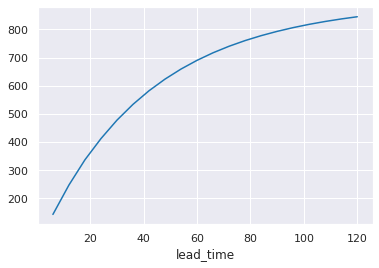

In [35]:
rmses_lr_6h_iter.plot();

In [37]:
rmses_lr_6h_iter.sel(lead_time=[3*24, 5*24])

<xarray.DataArray (lead_time: 2)>
array([740.37383243, 845.13098968])
Coordinates:
  * lead_time  (lead_time) int64 72 120

# Linear regression in Keras

In [58]:
X_train, y_train = create_training_data(data_train, 3*24)

In [59]:
net = tf.keras.models.Sequential([
    Dense(nlat*nlon, input_shape=(nlat*nlon, ))
])

In [60]:
net.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2048)              4196352   
Total params: 4,196,352
Trainable params: 4,196,352
Non-trainable params: 0
_________________________________________________________________


In [61]:
net.compile(keras.optimizers.Adam(1e-4), 'mse')

In [63]:
net.fit(X_train.reshape((-1, nlat*nlon)), y_train.reshape((-1, nlat*nlon)), epochs=50, batch_size=1024)

Epoch 1/50
333048/333048 [==============================] - 4s 12us/sample - loss: 0.4642
Epoch 2/50
333048/333048 [==============================] - 4s 13us/sample - loss: 0.4641
Epoch 3/50
333048/333048 [==============================] - 4s 13us/sample - loss: 0.4637
Epoch 4/50
333048/333048 [==============================] - 4s 13us/sample - loss: 0.4636
Epoch 5/50
333048/333048 [==============================] - 4s 13us/sample - loss: 0.4635
Epoch 6/50
333048/333048 [==============================] - 4s 13us/sample - loss: 0.4633
Epoch 7/50
333048/333048 [==============================] - 4s 13us/sample - loss: 0.4630
Epoch 8/50
333048/333048 [==============================] - 4s 13us/sample - loss: 0.4631
Epoch 9/50
333048/333048 [==============================] - 4s 13us/sample - loss: 0.4626
Epoch 10/50
333048/333048 [==============================] - 4s 13us/sample - loss: 0.4627
Epoch 11/50
333048/333048 [==============================] - 4s 13us/sample - loss: 0.4625
Epoch 12

## Random forest with PCA

### Directly forecast 3 and 5 days

In [20]:
lead_time = 3*24

In [21]:
X_train, y_train = create_training_data(data_train, lead_time_h)

In [50]:
X_test, y_test, valid_time = create_training_data(data_test, lead_time_h, return_valid_time=True)

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

In [46]:
X_train_flat = X_train.reshape((-1, nlat*nlon))
y_train_flat = y_train.reshape((-1, nlat*nlon))

In [32]:
X_train_flat.shape

(333114, 2112)

In [57]:
pca = PCA(n_components=200)

In [58]:
pca.fit(X_train_flat)

PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [59]:
pca.explained_variance_ratio_.sum()

0.9841005488893745

In [60]:
X_train_pca = pca.transform(X_train_flat)
y_train_pca = pca.transform(y_train_flat)

In [61]:
rf = RandomForestRegressor(n_estimators=20, min_samples_leaf=500, verbose=1, n_jobs=10)

In [62]:
rf.fit(X_train_pca, y_train_pca)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:  8.8min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=500, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=10,
                      oob_score=False, random_state=None, verbose=1,
                      warm_start=False)

In [63]:
preds = pca.inverse_transform(rf.predict(pca.transform(X_test.reshape((-1, nlat*nlon))))).reshape((-1, nlat, nlon))

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.3s finished


In [64]:
fc_rf = xr.DataArray(
    preds * data_std + data_mean, 
    dims=['time', 'lat', 'lon'],
    coords={
        'time': valid_time,
        'lat': data_test.lat,
        'lon': data_test.lon
    }
)

In [65]:
compute_weighted_rmse(fc_rf, z500_valid).values

array(789.25337295)

In [19]:
def train_rf(lead_time_h):
    X_train, y_train = create_training_data(data_train, lead_time_h)
    X_test, y_test, valid_time = create_training_data(data_test, lead_time_h, return_valid_time=True)
    lr = LinearRegression()
    lr.fit(X_train.reshape((-1, nlat*nlon)), y_train.reshape((-1, nlat*nlon)))
    mse_train = mean_squared_error(
        y_train.reshape((-1, nlat*nlon)), lr.predict(X_train.reshape((-1, nlat*nlon))))
    mse_test = mean_squared_error(
        y_test.reshape((-1, nlat*nlon)), lr.predict(X_test.reshape((-1, nlat*nlon))))
    print(f'Train MSE = {mse_train}'); print(f'Test MSE = {mse_test}')
    preds = lr.predict(X_test.reshape((-1, nlat*nlon))).reshape((-1, nlat, nlon))
    fc = xr.DataArray(
        preds * data_std + data_mean, 
        dims=['time', 'lat', 'lon'],
        coords={
            'time': valid_time,
            'lat': data_test.lat,
            'lon': data_test.lon
        }
    )
    return fc, lr                                   

In [76]:
fc_3d, lr_3d = train_lr(3*24)

Train MSE = 0.42326343059539795
Test MSE = 0.511426568031311


In [83]:
fc_3d.to_netcdf(f'{PREDDIR}/fc_lr_3d.nc'); to_pickle(lr_3d, f'{PREDDIR}/lr_3d.pkl')

In [77]:
rmse_lr_3d = compute_weighted_rmse(fc_3d, z500_valid).values; rmse_lr_3d

array(692.52623073)

In [84]:
fc_5d, lr_5d = train_lr(5*24)

Train MSE = 0.5344774723052979
Test MSE = 0.6529616713523865


In [85]:
fc_5d.to_netcdf(f'{PREDDIR}/fc_lr_5d.nc'); to_pickle(lr_5d, f'{PREDDIR}/lr_5d.pkl')

/home/rasp/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:244: FutureWarning: the 'box' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'box'
  dates = pd.to_datetime(dates, box=False)


In [86]:
rmse_lr_5d = compute_weighted_rmse(fc_5d, z500_valid).values; rmse_lr_5d

array(781.63945359)

## Train a simple CNN

In [76]:
X_train, y_train = create_training_data(data_train, 3*24)

In [77]:
X_train.shape

(333048, 32, 64)

In [78]:
import tensorflow.keras.backend as K
class PeriodicConv2D(tf.keras.layers.Conv2D):
    def __init__(self, filters, kernel_size, **kwargs):
        assert type(kernel_size) is int, 'Periodic convolutions only works for square kernels.'
        self.pad_width = (kernel_size - 1) // 2
        super().__init__(filters, kernel_size, **kwargs)
        assert self.padding == 'valid', 'Periodic convolution only works for valid padding.'
        assert sum(self.strides) == 2, 'Periodic padding only works for stride (1, 1)'
        
    def __call__(self, inputs, *args, **kwargs):
        # Input: [samples, lat, lon, filters]
        # Periodic padding in lon direction
        inputs_padded = K.concatenate(
            [inputs[:, :, -self.pad_width:, :], inputs, inputs[:, :, :self.pad_width, :]], axis=2)
        # Zero padding in the lat direction
        inputs_padded = tf.pad(inputs_padded, [[0, 0], [self.pad_width, self.pad_width], [0, 0], [0, 0]])
        return super().__call__(inputs_padded, *args, **kwargs)

In [79]:
net = tf.keras.models.Sequential([
    PeriodicConv2D(32, 5, padding='valid', input_shape=(33, 64, 1, ), activation='elu'),
    PeriodicConv2D(64, 5, padding='valid', activation='elu'),
    PeriodicConv2D(64, 5, padding='valid', activation='elu'),
    PeriodicConv2D(64, 5, padding='valid', activation='elu'),
    PeriodicConv2D(64, 5, padding='valid', activation='elu'),
    PeriodicConv2D(32, 5, padding='valid', activation='elu'),
    PeriodicConv2D(1, 5, padding='valid')
])

In [80]:
optim = tf.keras.optimizers.Adam(lr=1e-3)

In [81]:
net.compile(optim, 'mse')

In [83]:
net.save('/data/tmp/test.h5')

TypeError: ('Not JSON Serializable:', b'\n\rstrided_slice\x12\x0cStridedSlice\x1a\x15periodic_conv2d_input\x1a\x13strided_slice/stack\x1a\x15strided_slice/stack_1\x1a\x15strided_slice/stack_2*\x0b\n\x05Index\x12\x020\x03*\x07\n\x01T\x12\x020\x01*\x16\n\x10shrink_axis_mask\x12\x02\x18\x00*\x13\n\rellipsis_mask\x12\x02\x18\x00*\x10\n\nbegin_mask\x12\x02\x18\x0b*\x13\n\rnew_axis_mask\x12\x02\x18\x00*\x0e\n\x08end_mask\x12\x02\x18\x0f')

In [15]:
net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tf_op_layer_strided_slice (T [(None, 33, 2, 1)]        0         
_________________________________________________________________
tf_op_layer_strided_slice_1  [(None, 33, 2, 1)]        0         
_________________________________________________________________
tf_op_layer_concat (TensorFl [(None, 33, 68, 1)]       0         
_________________________________________________________________
tf_op_layer_Pad (TensorFlowO [(None, 37, 68, 1)]       0         
_________________________________________________________________
periodic_conv2d_1 (PeriodicC (None, 33, 64, 32)        832       
_________________________________________________________________
tf_op_layer_strided_slice_2  [(None, 33, 2, 32)]       0         
_________________________________________________________________
tf_op_layer_strided_slice_3  [(None, 33, 2, 32)]       0

In [181]:
net.fit(X_train[..., None], y_train[..., None], epochs=200, batch_size=256,
        validation_split=0.1,
        callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0,
            patience=3,
            verbose=1, 
            mode='auto'
        )]
)

Train on 299743 samples, validate on 33305 samples
Epoch 1/200
299743/299743 [==============================] - 333s 1ms/sample - loss: 0.6347 - val_loss: 0.5246
Epoch 2/200
299743/299743 [==============================] - 337s 1ms/sample - loss: 0.4963 - val_loss: 0.4783
Epoch 3/200
299743/299743 [==============================] - 335s 1ms/sample - loss: 0.4643 - val_loss: 0.4536
Epoch 4/200
299743/299743 [==============================] - 330s 1ms/sample - loss: 0.4404 - val_loss: 0.4372
Epoch 5/200
299743/299743 [==============================] - 328s 1ms/sample - loss: 0.4225 - val_loss: 0.4314
Epoch 6/200
299743/299743 [==============================] - 329s 1ms/sample - loss: 0.4072 - val_loss: 0.4228
Epoch 7/200
299743/299743 [==============================] - 329s 1ms/sample - loss: 0.3952 - val_loss: 0.4122
Epoch 8/200
299743/299743 [==============================] - 329s 1ms/sample - loss: 0.3844 - val_loss: 0.4113
Epoch 9/200
299743/299743 [==============================] - 

In [16]:
net.save('./cnn.h5')

TypeError: ('Not JSON Serializable:', b'\n\rstrided_slice\x12\x0cStridedSlice\x1a\x17periodic_conv2d_1_input\x1a\x13strided_slice/stack\x1a\x15strided_slice/stack_1\x1a\x15strided_slice/stack_2*\x07\n\x01T\x12\x020\x01*\x0b\n\x05Index\x12\x020\x03*\x16\n\x10shrink_axis_mask\x12\x02\x18\x00*\x10\n\nbegin_mask\x12\x02\x18\x0b*\x13\n\rellipsis_mask\x12\x02\x18\x00*\x13\n\rnew_axis_mask\x12\x02\x18\x00*\x0e\n\x08end_mask\x12\x02\x18\x0f')

In [185]:
X_test, y_test, valid_time = create_training_data(data_test, 3*24, return_valid_time=True)
preds = net.predict(X_test[..., None], 1024).squeeze()
fc_cnn = xr.DataArray(
    preds * data_std + data_mean, 
    dims=['time', 'lat', 'lon'],
    coords={
        'time': valid_time,
        'lat': data_test.lat,
        'lon': data_test.lon
    }
)

In [186]:
compute_weighted_rmse(fc_cnn, z500_valid).values

array(608.04726821)

## Train a simple CNN with periodic convolutions

## Create predictions

In [45]:
net = tf.keras.models.load_model('./dense.h5')

In [46]:
max_lead_time_h = 5*24
max_fc_steps = max_lead_time_h // lead_time_h
max_fc_steps

20

In [47]:
data_test

<xarray.DataArray 'z' (time: 17520, lat: 33, lon: 64)>
array([[[-2.772719, -2.772719, ..., -2.772719, -2.772719],
        [-2.817852, -2.768056, ..., -2.921149, -2.868601],
        ...,
        [-2.571951, -2.543243, ..., -2.630329, -2.598651],
        [-2.482641, -2.482641, ..., -2.482641, -2.482641]],

       [[-2.769329, -2.769329, ..., -2.769329, -2.769329],
        [-2.814672, -2.768004, ..., -2.913733, -2.863144],
        ...,
        [-2.573751, -2.542608, ..., -2.641346, -2.603311],
        [-2.500863, -2.500863, ..., -2.500863, -2.500863]],

       ...,

       [[-3.549458, -3.549458, ..., -3.549458, -3.549458],
        [-4.000619, -3.937664, ..., -4.139132, -4.067013],
        ...,
        [-4.448551, -4.583467, ..., -4.221824, -4.325862],
        [-4.825036, -4.825036, ..., -4.825036, -4.825036]],

       [[-3.55071 , -3.55071 , ..., -3.55071 , -3.55071 ],
        [-4.006972, -3.938653, ..., -4.154857, -4.079092],
        ...,
        [-4.40637 , -4.544987, ..., -4.185269, -

In [48]:
fcs = []
state = data_test.values
for fc_step in range(max_fc_steps):
    state = net.predict(state, batch_size=512)
    fcs.append(state * data_std.values + data_mean.values)

In [49]:
fcs = xr.DataArray(
    np.array(fcs), 
    dims=['lead_time', 'time', 'lat', 'lon'],
    coords={
        'lead_time': np.arange(lead_time_h, max_lead_time_h + lead_time_h, lead_time_h),
        'time': data_test.time,
        'lat': data_test.lat,
        'lon': data_test.lon
    }
)

In [50]:
fcs

<xarray.DataArray (lead_time: 20, time: 17520, lat: 33, lon: 64)>
array([[[[50762.71 , ..., 50762.535],
         ...,
         [51304.125, ..., 51304.137]],

        ...,

        [[49792.992, ..., 49792.863],
         ...,
         [48702.67 , ..., 48702.68 ]]],


       ...,


       [[[49085.89 , ..., 49085.668],
         ...,
         [52473.37 , ..., 52473.387]],

        ...,

        [[48331.152, ..., 48330.93 ],
         ...,
         [50741.465, ..., 50741.48 ]]]], dtype=float32)
Coordinates:
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120
  * time       (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
  * lat        (lat) float64 -90.0 -84.38 -78.75 -73.12 ... 78.75 84.38 90.0
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4

In [51]:
z500_valid = load_test_data(DATADIR)

In [52]:
z500_valid

<xarray.DataArray 'z' (time: 17520, lat: 33, lon: 64)>
dask.array<shape=(17520, 33, 64), dtype=float32, chunksize=(8760, 33, 64)>
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -90.0 -84.38 -78.75 -73.12 ... 73.12 78.75 84.38 90.0
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential

In [53]:
rmses = []
for lead_time in fcs.lead_time:
    fc = fcs.sel(lead_time=lead_time)
    fc['time'] = fc.time + np.timedelta64(int(lead_time), 'h')
    rmses.append(compute_weighted_rmse(fc, z500_valid).values)

In [54]:
rmses

[array(265.26386813),
 array(382.27181033),
 array(503.78351699),
 array(616.54727509),
 array(719.42553241),
 array(812.34455625),
 array(896.30277518),
 array(972.67306478),
 array(1042.65710535),
 array(1107.04434893),
 array(1166.37414181),
 array(1221.5059248),
 array(1273.31261664),
 array(1322.69871868),
 array(1370.38316715),
 array(1416.96057965),
 array(1462.9857573),
 array(1508.78888589),
 array(1554.49982908),
 array(1600.22620626)]

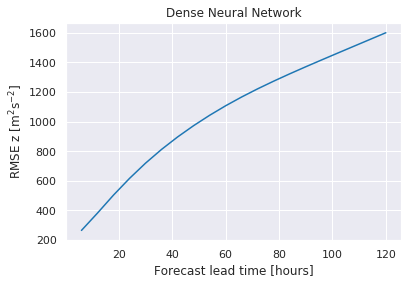

In [55]:
plt.plot(fcs.lead_time, rmses)
plt.ylabel(r'RMSE z [m$^2$s$^{-2}$]')
plt.xlabel('Forecast lead time [hours]')
plt.title('Dense Neural Network');

In [56]:
fcs.time[0]

<xarray.DataArray 'time' ()>
array('2017-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2017-01-01
Attributes:
    long_name:  time

In [57]:
z500_valid.time[0]

<xarray.DataArray 'time' ()>
array('2017-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2017-01-01
Attributes:
    long_name:  time

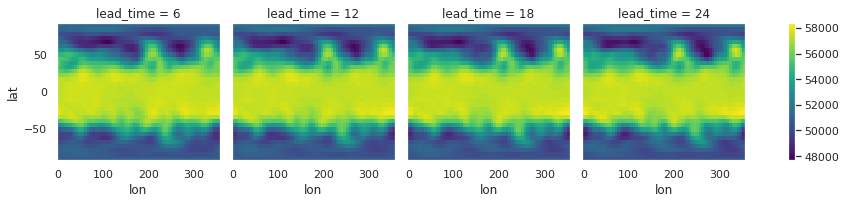

In [58]:
fcs.isel(time=0, lead_time=slice(0, 4)).plot(col='lead_time')

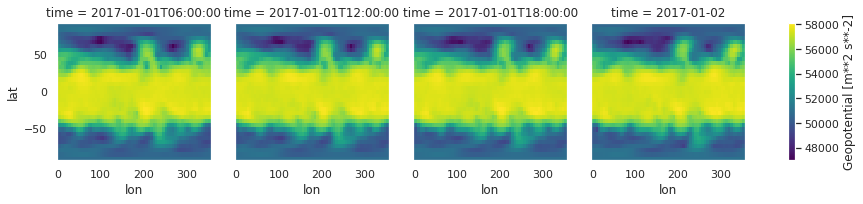

In [59]:
z500_valid.isel(time=slice(6, 6*4+6, 6)).plot(col='time')

## Create comparison plot